In [1]:
# ========================
# 0. IMPORTS
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, RepeatVector, TimeDistributed,
                                    MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D,
                                    Conv1D)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
import os
import gc
import tensorflow.keras.backend as K
import joblib
from tensorflow.keras.models import load_model

# ========================
# 1. CONFIGURATION
# ========================
INPUT_STEPS = 32
TEST_SIZE_POURCENTAGE = 1
TEST_RATIO = 0.05

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [2]:

# ========================
# 2. DEVICE SETUP
# ========================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")



✅ GPU is available and will be used.


In [3]:
# ========================
# 4. LOAD TEST SET
# ========================
# Load the test set from CSV
test_set_path = '../../../data/preprocessed_data.csv'
df_test = pd.read_csv(test_set_path, delimiter=',')
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'], errors='coerce')
df_test.set_index('DateTime', inplace=True)

# List of columns to drop (replace with your actual column names)
columns_to_drop = ['500UZ0009E01.LZI0012A.MEAS', '505D002D01.TI0012.MEAS', '530K001S01.FI0007.MEAS','530R001D01.FIC0029.MEAS']

# Drop them from both train and test dataframes
df_test.drop(columns=columns_to_drop, inplace=True, errors='ignore')
# Calculate number of rows to remove (0.05% of total length)
#n_rows_to_remove = int(len(df_test) * 0.05)

# Remove the last n_rows_to_remove rows
#df_test = df_test.iloc[:-n_rows_to_remove-1]

# Verify the new length
#print(f"Original length: {len(df_test) + n_rows_to_remove}")
#print(f"New length: {len(df_test)}")
#print(f"Removed {n_rows_to_remove} rows (5%)")
#print(f"✅ Loaded test set with {len(df_test)} samples from {test_set_path}")

# Extract labels from test set if they exist
if 'labels' in df_test.columns:
    print("✅ Found 'labels' column in test set.")
    all_test_labels = df_test['labels'].copy()
    df_test_features = df_test.drop(columns=['labels'])
else:
    print("⚠️ No 'labels' column found in test set. Will assume all samples are normal.")
    all_test_labels = pd.Series(np.zeros(len(df_test)))
    df_test_features = df_test.copy()

✅ Found 'labels' column in test set.


In [4]:
num_ones = (df_test['labels'] == 1).sum()
print(f"✅ Number of anomalies (labels == 1): {num_ones}")

✅ Number of anomalies (labels == 1): 2027


In [5]:
df_test.shape

(30103, 23)

In [6]:
# ========================
# 5. NORMALIZE DATA
# ========================
# Normalize detection dataset
scaler_detection = joblib.load("detection_scaler.pkl")

# Normalize test dataset - using the same scaler as detection dataset for consistency
scaled_data_test = scaler_detection.transform(df_test_features.values)
test_data_scaled = pd.DataFrame(scaled_data_test, index=df_test_features.index, 
                             columns=df_test_features.columns).astype(np.float32)

# joblib.dump(scaler_detection, "detection_scaler.pkl")

print(f"✅ Scaled test dataset shape: {test_data_scaled.shape}")



✅ Scaled test dataset shape: (30103, 22)


In [7]:
# ========================
# 5. CREATE SEQUENCES
# ========================
def create_sequences(data, input_steps):
    X = []
    i = 0
    while i + input_steps <= len(data):
        X.append(data[i:i+input_steps])
        i += input_steps  # advance by input_steps to avoid overlap
    return np.array(X, dtype=np.float32)

In [55]:
TEST_SIZE_POURCENTAGE = 1

# Split for test set
split_idx_test = int(TEST_SIZE_POURCENTAGE * len(test_data_scaled))
test_data = test_data_scaled.iloc[:split_idx_test]
test_labels = all_test_labels.iloc[:split_idx_test]

print(f"✅ Detection model - Testing samples: {len(test_data)}")

✅ Detection model - Testing samples: 30103


In [56]:
# ========================
# 8. BUILD AND TRAIN LSTM AUTOENCODER
# ========================

def create_ae_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)], dtype=np.float32)


lstm_ae = load_model("best_lstm_autoencoder.h5")

In [57]:
# Use the last 3000 points of the test data for simulation
test_data_tail = test_data.tail(1442).reset_index(drop=True)
test_labels_tail = test_labels.tail(1442).reset_index(drop=True)

# test_data_tail = test_data.copy()
# test_labels_tail = test_labels.copy()

# ========================
# 9. REAL-TIME SIMULATION WITH MANUAL THRESHOLD CONTROL
# ========================
simulation_y = create_sequences(test_data_tail.values, INPUT_STEPS)
# Create corresponding labels for evaluation

#
forecast_list = []
#reconstruction_list = []
reconstruction_errors = []
#true_windows = []

# Process each non-overlapping sequence individually
for i in range(len(simulation_y)):
    window_y_true = simulation_y[i]  # shape (INPUT_STEPS, features)
    input_seq = np.expand_dims(window_y_true, axis=0)  # shape (1, INPUT_STEPS, features)
    
    # Skip empty or malformed input
    if input_seq.shape[1] == 0:
        continue

    
    # Reconstruct using LSTM autoencoder
    y_reconstructed = lstm_ae.predict(input_seq, batch_size=32, verbose=1)[0]  # shape (INPUT_STEPS, features)
    
    # Calculate per-timestep reconstruction error
    timestep_errors = np.mean((window_y_true - y_reconstructed) ** 2, axis=1)  # shape (INPUT_STEPS,)
    
    reconstruction_errors.append(timestep_errors)

print("\n✅ Real-time simulation complete.")

1/1 [==============================] - 0s 83ms/step

✅ Real-time simulation complete.


In [11]:
timestep_errors.shape

(32,)

In [58]:
MANUAL_THRESHOLD=None
MANUAL_PERCENTILE=100
# Flatten the reconstruction errors list for threshold calculation
all_reconstruction_errors = np.concatenate(reconstruction_errors)

# Make sure we're only considering windows where we have both predictions and labels
min_length = min(len(test_labels_tail), len(all_reconstruction_errors))
true_labels_subset = test_labels_tail[:min_length]
errors_subset = all_reconstruction_errors[:min_length]

# Determine threshold to use
if MANUAL_THRESHOLD is not None:
    # Use manually specified threshold
    threshold = MANUAL_THRESHOLD
    print(f"\n✅ Using manually specified threshold: {threshold:.5f}")
else:
    # Use percentile-based threshold
    threshold = np.percentile(all_reconstruction_errors, MANUAL_PERCENTILE)
    print(f"\n✅ Using {MANUAL_PERCENTILE}th percentile threshold: {threshold:.5f}")


all_detected = (np.array(all_reconstruction_errors) > threshold).astype(np.int32)

# Apply threshold to get anomaly flags
#anomaly_flags_list = [errors > threshold for errors in reconstruction_errors]
#all_detected = np.concatenate([flags for flags in anomaly_flags_list])


✅ Using 100th percentile threshold: 0.03397


In [13]:
threshold 

0.06917796283960342

In [14]:
all_reconstruction_errors.shape

(1440,)

In [59]:
# Make sure we're only considering windows where we have both predictions and labels
min_length = min(len(true_labels_subset), len(all_detected))
true_labels_subset = true_labels_subset[:min_length]
all_detected_subset = all_detected[:min_length]

# Print summary of anomalies
print(f"\nAnomaly detection summary:")
print(f"Number of true anomalies: {np.sum(true_labels_subset)}")
print(f"Number of detected anomalies: {np.sum(all_detected_subset)}")

# Compute metrics
precision = precision_score(true_labels_subset, all_detected_subset, zero_division=0)
recall = recall_score(true_labels_subset, all_detected_subset, zero_division=0)
f1 = f1_score(true_labels_subset, all_detected_subset, zero_division=0)

print(f"\n📈 Anomaly Detection Evaluation:")
print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1 Score:  {f1:.5f}")


Anomaly detection summary:
Number of true anomalies: 79
Number of detected anomalies: 0

📈 Anomaly Detection Evaluation:
Precision: 0.00000
Recall:    0.00000
F1 Score:  0.00000


In [16]:
all_detected.shape

(1440,)

In [17]:
true_labels_subset.shape

(1440,)

In [18]:
num_ones = np.sum(all_detected == 1)
print("Number of ones:", num_ones)

Number of ones: 0


In [19]:
num_ones = np.sum(true_labels_subset == 1)
print("Number of ones:", num_ones)

Number of ones: 92


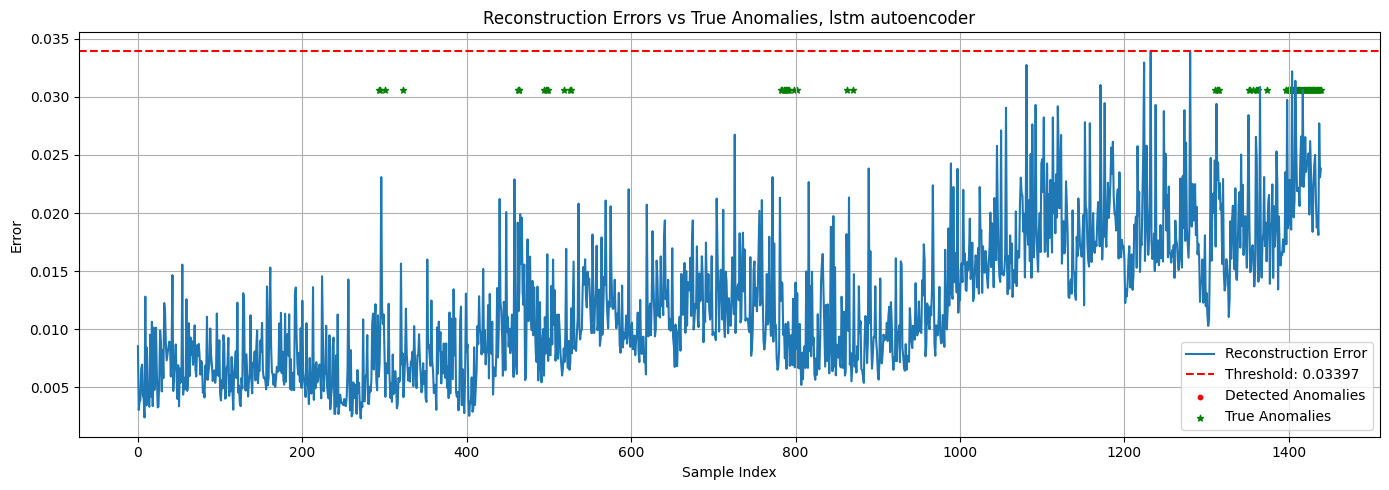


✅ Analysis complete.

To change the threshold:
1. Set MANUAL_THRESHOLD to a specific value to use that exact threshold
2. Set MANUAL_PERCENTILE to use a percentile-based threshold (current: 100th)
3. Re-run the script to see results with the new threshold


In [60]:
# ========================
# 10. PLOT RESULTS
# ========================
# Plot Reconstruction Errors with True Labels
plt.figure(figsize=(14,5))

# Ensure we're only plotting up to the minimum length we have data for
min_plot_len = min(len(all_reconstruction_errors), len(true_labels_subset))
plot_errors = all_reconstruction_errors[:min_plot_len]
plot_labels = true_labels_subset[:min_plot_len]
plot_detected = all_detected_subset[:min_plot_len]

plt.plot(plot_errors, label='Reconstruction Error')
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.5f}')

# Detected anomalies
detected_indices = np.where(plot_detected == 1)[0]
plt.scatter(detected_indices,
            plot_errors[detected_indices],
            color='red', label='Detected Anomalies', s=10)

# True anomalies
true_anomaly_indices = np.where(plot_labels == 1)[0]
if len(true_anomaly_indices) > 0:
    plt.scatter(true_anomaly_indices,
                np.ones_like(true_anomaly_indices) * np.max(plot_errors)*0.9,
                color='green', marker='*', label='True Anomalies', s=20)
else:
    print("No true anomalies found in the subset of data being visualized")

plt.title("Reconstruction Errors vs True Anomalies, lstm autoencoder")
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_errors_with_threshold.png")
plt.show()

print("\n✅ Analysis complete.")
print("\nTo change the threshold:")
print("1. Set MANUAL_THRESHOLD to a specific value to use that exact threshold")
print("2. Set MANUAL_PERCENTILE to use a percentile-based threshold (current: {}th)".format(MANUAL_PERCENTILE))
print("3. Re-run the script to see results with the new threshold")

In [61]:
df_test_copy = df_test.copy()

df_test_copy = df_test_copy.iloc[:split_idx_test]
original_test_labeled = df_test_copy.tail(1442)

In [36]:
original_test_labeled.shape

(1442, 23)

In [37]:
all_detected_subset.shape

(1440,)

In [62]:
original_test_labeled = original_test_labeled[:1440]

In [25]:
original_test_labeled.shape

(1440, 23)

In [63]:
original_test_labeled = original_test_labeled.copy()  # Optional, avoids SettingWithCopyWarning
original_test_labeled['labels'] = 0
original_test_labeled['labels'] = all_detected_subset  # force value assignment

In [64]:
num_ones = np.sum(original_test_labeled['labels'] == 1)
print("Number of ones:", num_ones)

Number of ones: 0


In [40]:
# Define the attribute of interest
attribute  = "530R002D02.TI0037.MEAS"
attribute2 = "530M105D01.TIC0022.MEAS"
# Calculate the 10th and 90th percentile thresholds
lower_bound = 680
upper_bound = 730

In [65]:
# Step 2: Add attribute-based anomalies without removing model detections
original_test_labeled.loc[
    (original_test_labeled[attribute] > upper_bound),
    'labels'
] = 1

In [30]:
# Step 2: Add attribute-based anomalies without removing model detections
original_test_labeled.loc[
    (original_test_labeled[attribute2] < lower_bound) |
    (original_test_labeled[attribute] > upper_bound),
    'labels'
] = 1


In [66]:
num_ones = np.sum(original_test_labeled['labels'] == 1)
print("Number of ones:", num_ones)

Number of ones: 53


In [67]:
original_test_labeled_final = original_test_labeled[0:1440]

In [68]:
# Save with index
original_test_labeled_final.to_csv("labeled_test_set_with_predictions.csv", index=True)

print("\n✅ Original test set labeled and saved as 'labeled_test_set_with_predictions.csv'")


✅ Original test set labeled and saved as 'labeled_test_set_with_predictions.csv'


In [69]:
num_ones = np.sum(original_test_labeled_final['labels'] == 1)
print("Number of ones:", num_ones)

Number of ones: 53


In [70]:
original_test_labeled_final

,520MX051D01.FIC0028.MEAS,520D007D02.TI0058.MEAS,530R001D01.FI0043.MEAS,530E001D01.FIC0015.MEAS,530R001D01.FIC0030.MEAS,530R001D01.FIC0047.MEAS,530C021D01.FIC0203.MEAS,530R001D02.FIC0230.MEAS,530R002D02.LI0010.MEAS,530M102D01.LIC0011.MEAS,...,530R002D02.TI0037.MEAS,530F001D01.TIC0012.MEAS,530M105D01.TIC0022.MEAS,530UZ1099E01.TZI0068A.MEAS,530M103D01.ZI2103A.MEAS,530M104D01.ZI2104A.MEAS,530M105D01.ZI2105A.MEAS,535D005D01.LI0011.MEAS,535INT920D01.TI0046.MEAS,labels
DateTime,,,,,,,,,,,,,,,,,,,,,
2024-12-03 17:18:00,4.526224,128.748047,2650.876465,1208.079224,2564.053711,309.998505,135.635132,5.495455,47.520363,30.319614,...,723.362488,143.062500,682.204102,158.223450,20.548828,19.347656,60.816406,13.179941,58.453125,0
2024-12-03 17:21:00,4.526224,128.748047,2647.280273,1205.621704,2558.945312,310.041412,135.638504,5.495455,48.034554,30.020466,...,723.310974,143.140625,682.083984,157.960922,20.285156,19.347656,60.902344,13.179701,58.351562,0
2024-12-03 17:24:00,4.526224,128.507812,2648.681396,1202.663818,2565.543945,310.122437,135.618988,5.495455,50.629436,30.627666,...,723.310974,143.171875,681.152344,157.960922,20.673828,19.347656,61.302734,13.066221,58.355469,0
2024-12-03 17:27:00,4.526224,128.501953,2648.176270,1204.921143,2566.624268,310.162842,135.644791,5.495455,50.865265,26.837736,...,723.860962,143.234375,681.823242,157.698410,20.646484,19.347656,61.292969,13.074998,58.251953,0
2024-12-03 17:30:00,4.526224,128.619141,2654.141602,1204.876221,2562.370361,309.737427,135.528778,5.495455,52.113403,25.777952,...,724.032837,143.140625,683.062500,157.435898,19.974609,19.347656,61.507812,13.290003,58.353516,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-06 17:03:00,4.526224,127.798828,2659.242432,1205.352173,2567.460205,311.078369,135.508728,5.497415,53.332291,30.541973,...,730.598450,141.250000,684.685547,156.910873,21.205078,22.390625,65.121094,13.131935,57.257812,1
2024-12-06 17:06:00,4.526224,127.933594,2652.085938,1205.320923,2568.482422,311.319336,135.597992,5.497415,52.846977,29.377831,...,730.804688,141.140625,684.240234,156.779617,20.718750,22.390625,64.814453,13.237483,57.257812,1
2024-12-06 17:09:00,4.526224,128.173828,2640.503418,1205.632080,2569.037354,310.100586,135.851501,5.497415,53.541771,29.265095,...,731.835938,141.093750,684.811523,156.648346,20.875000,22.390625,64.916016,13.247736,57.150391,1
